In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [2]:
# total number of actions
df.shape[0]

8188

In [3]:
# number of unique users
df.id.unique().size

6328

In [4]:
# size of control group and experiment group
df_unique_users = df.drop_duplicates('id')
df_unique_users['group'].value_counts()

control       3332
experiment    2996
Name: group, dtype: int64

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [5]:
# duration of this experimentataset are ordered by timestamp in increasing order
df.timestamp = pd.to_datetime(df.timestamp)
start = df.iloc[0][0]
end = df.iloc[-1][0]

end - start

Timedelta('115 days 16:41:40.789831')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [6]:
# action types in this experiment
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

* The control and experiment pages could have different numbers of total visitors
* More total clicks could occur in one version, even if there is a greater percentage of clicks in the other version.

That's right! Getting the proportion of the users who click is more effective than getting the number of users who click when comparing groups of different sizes.

### 5. Define the click through rate (CTR) for this experiment.

The number of unique visitors who click at least once divided by the number of unique visitors who view the page

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: CTR_{new} - CTR_{old} <= 0 $$
$$H_1: CTR_{new} - CTR_{old} > 0 $$

As we saw, this dataset includes view and click actions on the home page of Audacity's site,  
from users that were shown the control and experimental versions of the A/B test.  

Our task is to analyze these actions to see if there
was a significant difference in performance for the two versions.

To do this, let's first compute the click-through rate for each group.

Let's start with the control group.

We can extract all the actions from the control group like this.

In [7]:
control_df = df.query('group == "control"')

Now, to compute the click-through rate,
we'll divide the number of unique users who actually click
the Explore courses button by the total number of unique users who viewed the page.

In [8]:
control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()

This gives us a click-through rate of about 28 percent.

In [9]:
control_ctr

0.2797118847539016

Let's do the same thing for the experiment group.
Again, we'll take all the click actions,
get the unique number of users,
and divide that number by the number of unique users who viewed the page.

In [10]:
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

That gives us a click-through rate of about 31 percent.

In [11]:
experiment_ctr

0.3097463284379172

So in this sample, the experiment group's click-through rate was
higher than the control group's click-through rate by about 3 percent.

In [12]:
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030034443684015644

Now that we know the observed difference in this sample,
we have to see if this difference is significant and not just due to chance.

Let's bootstrap the sample to simulate
the sampling distribution for the difference in proportions.

In [13]:
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace = True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr  - control_ctr)

Let's take a look at our sampling distribution.

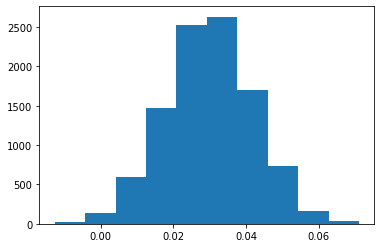

In [14]:
plt.hist(diffs);

If we remember from the previous lesson,
we can compute the p-value for our statistic which is
the observed difference in proportions by simulating
the distribution under the null hypothesis and then
finding the probability that our statistic came from this distribution.

To simulate from the null,
we'll create a normal distribution centered at zero (because our null suggests that difference is zero!),
with the same standard deviation as our sampling distribution we simulated here.

In [15]:
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

We could see the null distribution here.



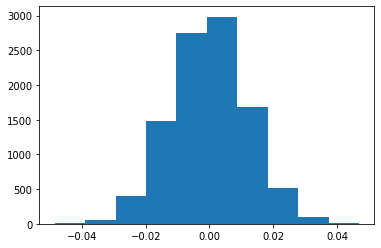

In [16]:
plt.hist(null_vals);

And this is where our observed statistic falls.

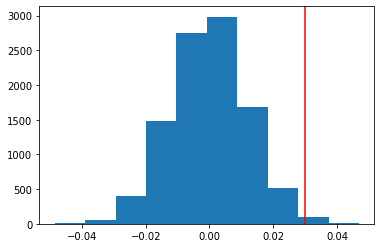

In [17]:
plt.hist(null_vals);
plt.axvline(x = obs_diff, color = 'red');

We can find the p-value like this:



In [18]:
(null_vals > obs_diff).mean()

0.0066

as these are
all the null values that are more extreme than our statistic in favor of our alternative.

With a p-value of approximately a half of percent,
the difference in click-through rates for the control and
experiment groups does appear to be significant.



We can reject the null hypothesis,
and based on these results,
it looks like Audacity should launch the new version of the home page.